SIMPLEST possible application case: don't do any fine-tuning of existing model weights; just learn a frame-level decoder. Can we do it?

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
torch.cuda.device_count()

1

In [3]:
from pathlib import Path

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import torch
import transformers
from transformers import AutoConfig
from transformers import Wav2Vec2Model
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from models import Vocabulary
from models.transformer import Wav2Vec2ForSpeechClassification, DataCollator, \
    drop_wav2vec_layers
from utils.timit import TimitCorpus

In [6]:
datasets.disable_caching()

In [7]:
model_dir = "out/pure_hugging/testrun2/checkpoint-560"
device = "cuda:0"

In [8]:
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_dir).to(device)

In [9]:
corpus_path = "timit_corpus"

corpus = datasets.load_from_disk(corpus_path)
phone_vocab = Vocabulary.from_index2token(model.config.output_vocab)

In [10]:
processor = transformers.Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

In [11]:
def compute_metrics(p: transformers.EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = preds.reshape((-1, preds.shape[-1]))

    label_mask, label_ids = p.label_ids
    labels = label_ids.reshape((-1, preds.shape[-1]))

    def evaluate_label(j):
        preds_j = preds[:, j]
        labels_j = labels[:, j]

        preds_j = preds_j[label_mask == 1]
        labels_j = labels_j[label_mask == 1]
        if labels_j.std() == 0:
            # Only one class. Quit
            return None
        return roc_auc_score(labels_j, preds_j)

    roc_auc_scores = [evaluate_label(j) for j in range(preds.shape[-1])]
    return {"roc_auc": np.mean([score for score in roc_auc_scores if score is not None])}

In [12]:
coll = DataCollator(processor=processor, model=model, padding=True,
                    num_labels=len(phone_vocab.index2token))
training_args = TrainingArguments(
    do_train=False,
    do_eval=True,
    do_predict=True,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    use_cpu=device == "cpu",
    no_cuda=device == "cpu",
    output_dir=model_dir,
    resume_from_checkpoint=model_dir,
    label_names=["label_mask", "labels"],
)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=coll,
    compute_metrics=compute_metrics,
    train_dataset=corpus["train"],
    eval_dataset=corpus["test"],
    tokenizer=processor.feature_extractor,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Evaluate

In [176]:
# Determine optimal cut-off probability for each phone
from sklearn.metrics import roc_curve

# Get predictions
trainer.model.eval()
with torch.no_grad():
    preds = trainer.predict(corpus["train"])
    label_mask, labels = preds.label_ids
    preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions

***** Running Prediction *****
  Num examples = 4620
  Batch size = 32


IndexError: boolean index did not match indexed array along dimension 1; dimension is 63 but corresponding boolean dimension is 389

In [181]:
# Get optimal cut-off for each phone
optimal_thresholds = []
for j in range(preds.shape[-1]):
    preds_j = preds[:, :, j]
    labels_j = labels[:, :, j]

    mask = label_mask == 1
    preds_j = preds_j[mask]
    labels_j = labels_j[mask]

    fpr_j, tpr_j, thresholds_j = roc_curve(labels_j, preds_j, pos_label=1)
    optimal_thresholds.append(thresholds_j[np.argmax(tpr_j - fpr_j)])

optimal_thresholds = torch.tensor(optimal_thresholds)
optimal_thresholds

/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true posi

tensor([    inf,     inf, -2.8064, -2.4872, -3.3766, -2.8630, -4.8791, -3.0122,
        -4.1967, -2.6591, -3.3862, -2.8447, -3.1061, -4.8204, -2.3846, -1.8433,
        -3.9040, -3.3291, -2.5332, -4.5378, -4.3497, -5.1365, -6.6876,     inf,
        -3.5559, -3.2806, -2.7358, -3.1028, -2.7209,     inf, -4.8558, -4.4524,
        -2.2923, -1.4488, -1.6855, -4.1714, -1.5859, -1.5114, -1.4381, -1.7888,
        -1.3698, -4.1267, -4.8838, -3.4783, -5.1415, -2.1461,     inf, -2.1254,
        -3.4167, -1.3847, -1.1914, -3.2754, -2.0917, -1.6236, -4.9498, -5.5664,
        -5.3984, -3.3494, -2.8825, -2.8827, -3.7201, -2.1047, -5.7112])

In [40]:
eval_predictions = trainer.predict(corpus["test"])

In [183]:
def add_predictions(batch, idxs):
    # batch = coll(batch).to(model.device)
    # # print(list(batch.keys()))
    # # features = processor(batch["input_values"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    # # input_values = features.input_values.to(model.device)

    # with torch.no_grad():
    #     logits = model(batch.input_values).logits.cpu()
    # preds = (logits > optimal_thresholds).int().numpy()

    logits = eval_predictions.predictions[idxs]
    preds = (logits > optimal_thresholds.numpy()).astype(int)

    # TODO trim based on label padding to match actual input length
    batch["score"] = logits
    batch["distance_from_decision_threshold"] = logits - optimal_thresholds.numpy()
    batch["predicted"] = preds

    return batch

eval_result = corpus["test"].select(range(30)).map(add_predictions, batched=True, batch_size=8, with_indices=True)

def compute_accuracy(item, idx):
    label_mask, labels = eval_predictions.label_ids
    label_mask = label_mask[idx] == 1
    labels = labels[idx]

    item["real_frames"] = label_mask.sum()
    item["correct"] = (np.array(item["predicted"])[label_mask] == labels[label_mask])
    item["accuracy"] = item["correct"].mean()
    return item

eval_result = eval_result.map(compute_accuracy, batched=False, with_indices=True)

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

In [185]:
# DEV: because `TilingWordFeatureExtractor` does its own internal sorting, the phone
# targets don't actually match model internal targets, but rather the sorted phone
# vocabulary. Match this here in the viz.
viz_columns = sorted(phone_vocab.index2token)

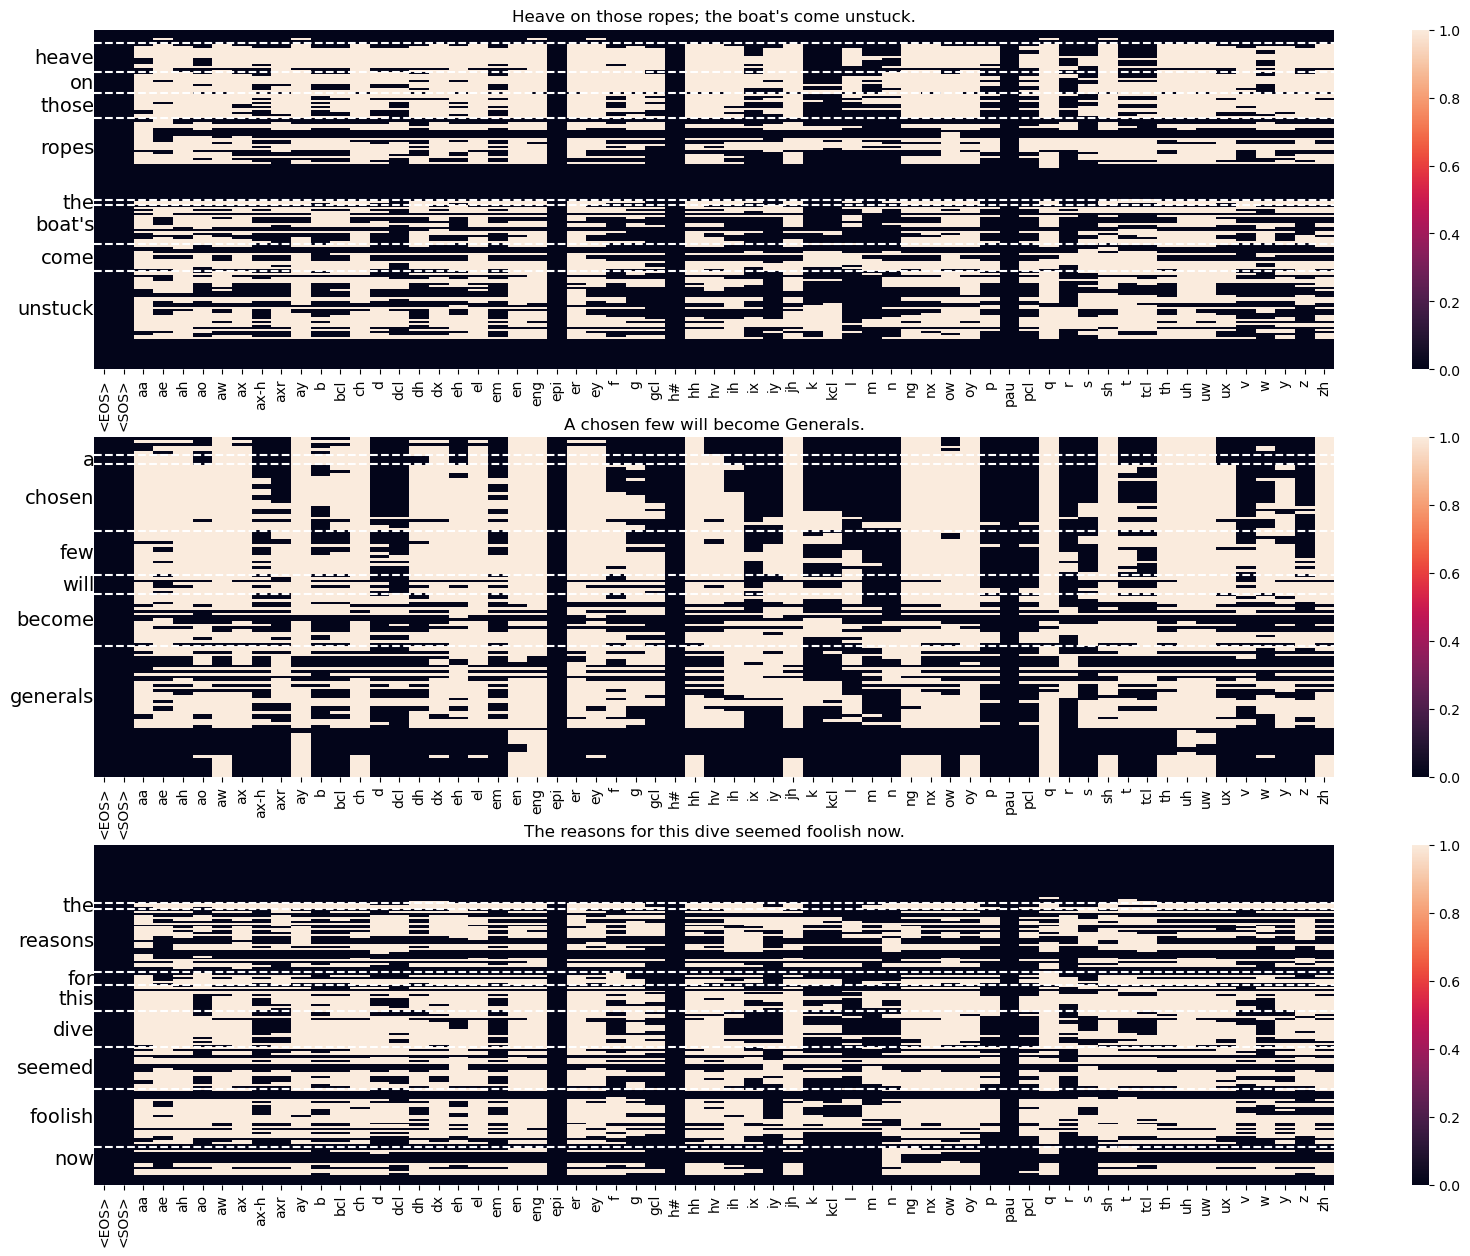

In [189]:
# viz phoneme predictions
n_to_plot = 3
f, axs = plt.subplots(n_to_plot, figsize=(20, 5 * n_to_plot))
plot_idxs = np.random.choice(len(eval_result), n_to_plot, replace=False).tolist()

for idx, ax in zip(plot_idxs, axs.ravel()):
    item = eval_result[idx]

    # compute compression ratio between input and output
    num_item_frames = item["real_frames"]
    num_input_frames = len(item["input_values"])#.shape[0]
    compression_ratio = num_item_frames / num_input_frames

    from matplotlib import pyplot as plt
    import seaborn as sns

    result = pd.DataFrame(item["predicted"][:num_item_frames],
                          columns=viz_columns)
    sns.heatmap(result, ax=ax)
    ax.set_title(item["text"])
    ax.set_yticks([])

    word_detail = item["word_detail"]
    for start, stop, word in zip(word_detail["start"], word_detail["stop"], word_detail["utterance"]):
        start = start * compression_ratio
        stop = stop * compression_ratio

        ax.axhline(start, color="white", linestyle="--")
        # show phone centered over its span
        ax.text(0, (start + stop) / 2, word, ha="right", va="center", fontsize=14)

    # f, ax = plt.subplots(figsize=(20, 5))

    # phonetic_detail = item["phonetic_detail"]
    # for start, stop, phone in zip(phonetic_detail["start"], phonetic_detail["stop"], phonetic_detail["utterance"]):
    #     ax.axvline(start, color="black", linestyle="--")
    #     # show phone centered over its span
    #     ax.text((start + stop) / 2, 0, phone, ha="center", va="center", fontsize=14)

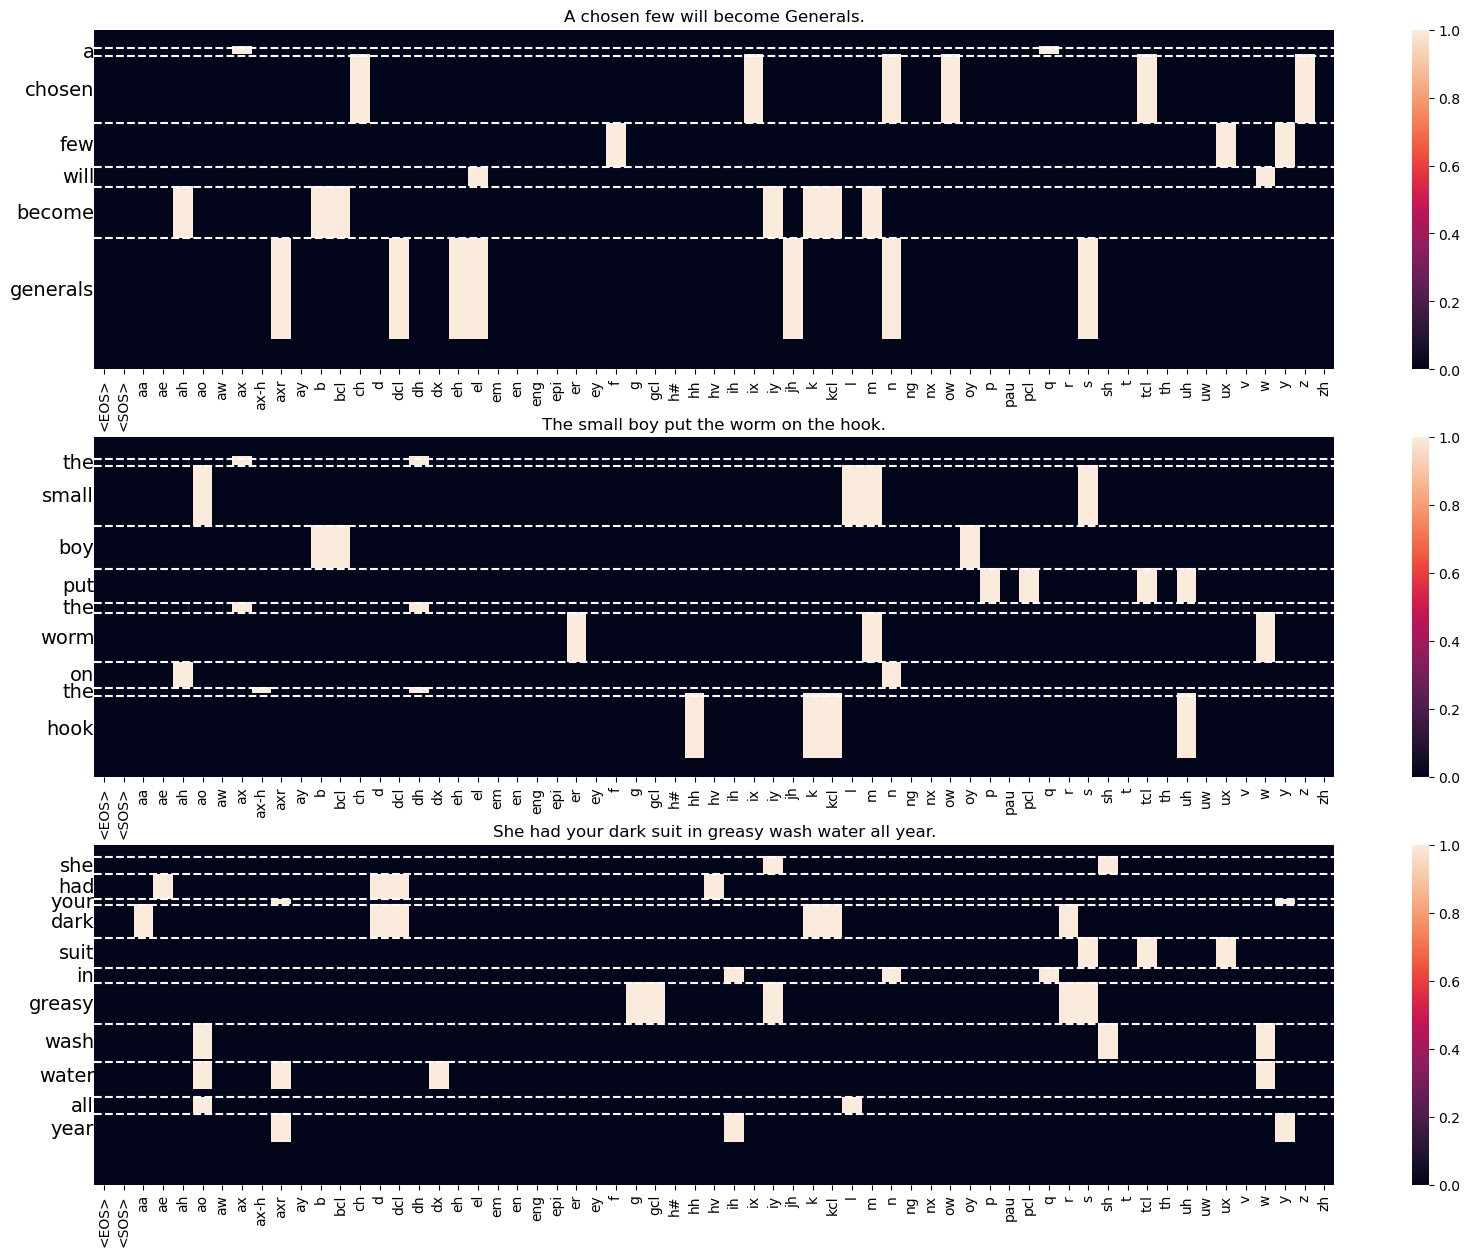

In [187]:
# viz labels
n_to_plot = 3
f, axs = plt.subplots(n_to_plot, figsize=(20, 5 * n_to_plot))
# Use same plot_idxs as above
# plot_idxs = np.random.choice(len(eval_result), n_to_plot, replace=False).tolist()

for idx, ax in zip(plot_idxs, axs.ravel()):
    item = eval_result[idx]

    # compute compression ratio between input and output
    num_item_frames = item["real_frames"]
    num_input_frames = len(item["input_values"])#.shape[0]
    compression_ratio = num_item_frames / num_input_frames

    from matplotlib import pyplot as plt
    import seaborn as sns

    label_mat = np.zeros_like(item["predicted"])
    for onset, offset, idx in item["phone_targets"]:
        onset = int(onset * compression_ratio)
        offset = int(offset * compression_ratio)
        label_mat[onset:offset, idx] = 1
    result = pd.DataFrame(label_mat[:num_item_frames], columns=viz_columns)
    sns.heatmap(result, ax=ax)
    ax.set_title(item["text"])
    ax.set_yticks([])

    word_detail = item["word_detail"]
    for start, stop, word in zip(word_detail["start"], word_detail["stop"], word_detail["utterance"]):
        start = start * compression_ratio
        stop = stop * compression_ratio

        ax.axhline(start, color="white", linestyle="--")
        # show phone centered over its span
        ax.text(0, (start + stop) / 2, word, ha="right", va="center", fontsize=14)

    # f, ax = plt.subplots(figsize=(20, 5))

    # phonetic_detail = item["phonetic_detail"]
    # for start, stop, phone in zip(phonetic_detail["start"], phonetic_detail["stop"], phonetic_detail["utterance"]):
    #     ax.axvline(start, color="black", linestyle="--")
    #     # show phone centered over its span
    #     ax.text((start + stop) / 2, 0, phone, ha="center", va="center", fontsize=14)

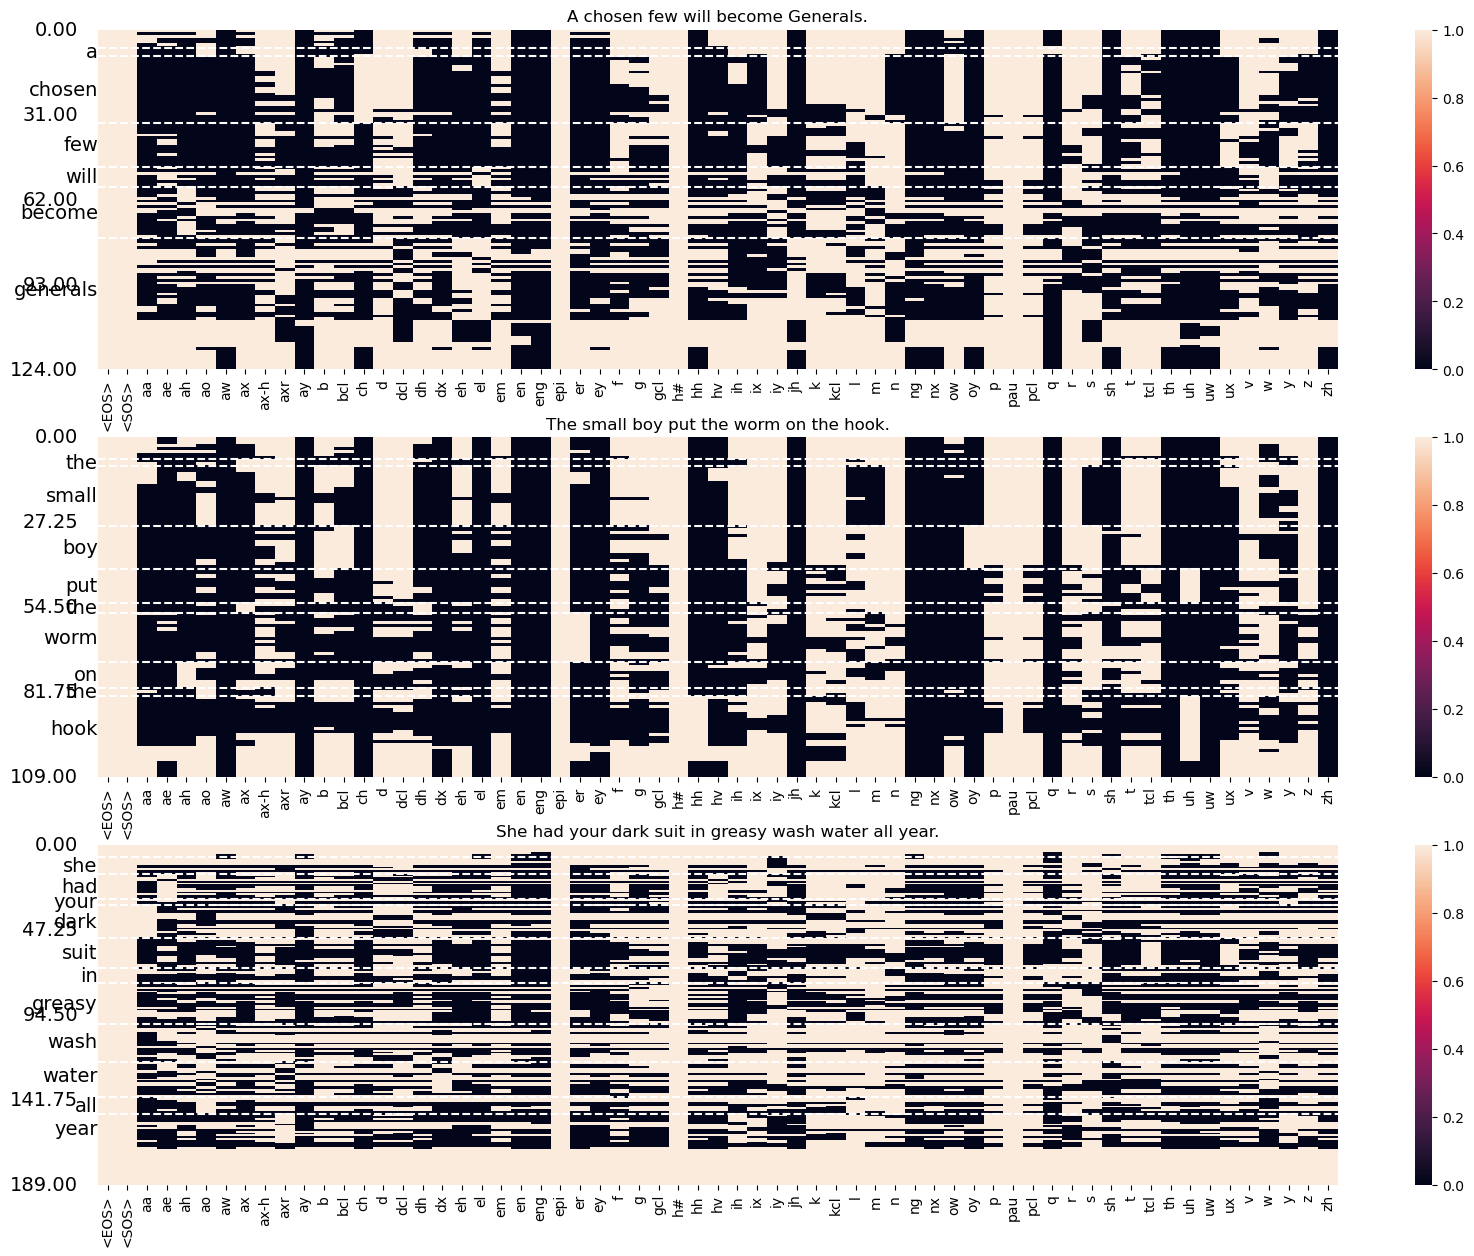

In [188]:
# viz labels
n_to_plot = 3
f, axs = plt.subplots(n_to_plot, figsize=(20, 5 * n_to_plot))
# Use same plot_idxs as above
# plot_idxs = np.random.choice(len(eval_result), n_to_plot, replace=False).tolist()

for idx, ax in zip(plot_idxs, axs.ravel()):
    item = eval_result[idx]

    # compute compression ratio between input and output
    num_item_frames = item["real_frames"]
    num_input_frames = len(item["input_values"])#.shape[0]
    compression_ratio = num_item_frames / num_input_frames

    from matplotlib import pyplot as plt
    import seaborn as sns

    result = pd.DataFrame(np.array(item["correct"])[:num_item_frames], columns=viz_columns)
    sns.heatmap(result, ax=ax)
    ax.set_title(item["text"])
    ax.set_yticks([])

    word_detail = item["word_detail"]
    for start, stop, word in zip(word_detail["start"], word_detail["stop"], word_detail["utterance"]):
        start = start * compression_ratio
        stop = stop * compression_ratio

        ax.axhline(start, color="white", linestyle="--")
        # show phone centered over its span
        ax.text(0, (start + stop) / 2, word, ha="right", va="center", fontsize=14)

    for y in np.linspace(*ax.get_ylim(), 5):
        ax.text(-1, y, f"{y:.2f}", ha="right", va="center", fontsize=14)

    # f, ax = plt.subplots(figsize=(20, 5))

    # phonetic_detail = item["phonetic_detail"]
    # for start, stop, phone in zip(phonetic_detail["start"], phonetic_detail["stop"], phonetic_detail["utterance"]):
    #     ax.axvline(start, color="black", linestyle="--")
    #     # show phone centered over its span
    #     ax.text((start + stop) / 2, 0, phone, ha="center", va="center", fontsize=14)

In [66]:
viz_df = pd.DataFrame(np.array(item["score"]), columns=viz_columns)
viz_df

,<EOS>,<SOS>,aa,ae,ah,ao,aw,ax,ax-h,axr,...,tcl,th,uh,uw,ux,v,w,y,z,zh
0,-7.570205,-7.281650,-3.310754,-3.584403,-4.012572,-3.953173,-5.915402,-3.879933,-6.583390,-3.966217,...,-2.327723,-6.026059,-6.209918,-6.174058,-4.440778,-4.798006,-4.016596,-5.159581,-3.177253,-6.905868
1,-7.541664,-7.240436,-3.360005,-3.587771,-4.033752,-3.922587,-5.881021,-3.880812,-6.568783,-3.993011,...,-2.381020,-5.989464,-6.193735,-6.158026,-4.446645,-4.806541,-3.935291,-5.187217,-3.172595,-6.886610
2,-7.618094,-7.322863,-3.316534,-3.602517,-4.035664,-3.952210,-5.959826,-3.889148,-6.623732,-3.983514,...,-2.329924,-6.055932,-6.243625,-6.209661,-4.450244,-4.817639,-4.006000,-5.185159,-3.157314,-6.947289
3,-7.671963,-7.358047,-3.391397,-3.640873,-4.104897,-3.952445,-5.997779,-3.950424,-6.677036,-3.997610,...,-2.399765,-6.102576,-6.288488,-6.238845,-4.463760,-4.798405,-3.969023,-5.222593,-3.135617,-6.994842
4,-7.618852,-7.339860,-3.276037,-3.578499,-4.043314,-3.956316,-5.974567,-3.895283,-6.617399,-3.989781,...,-2.272492,-6.061224,-6.242977,-6.203139,-4.436279,-4.834186,-4.024663,-5.207104,-3.146749,-6.953506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,-7.661308,-7.392318,-3.403154,-3.626971,-4.157769,-4.038993,-6.043951,-4.004032,-6.687026,-3.938174,...,-2.342331,-6.089671,-6.300941,-6.246663,-4.495343,-4.866575,-4.004111,-5.145922,-3.158442,-7.002084
244,-7.637899,-7.368842,-3.389560,-3.609489,-4.150385,-3.984259,-6.015603,-3.991921,-6.673780,-3.932949,...,-2.380921,-6.073878,-6.287264,-6.229930,-4.495555,-4.867246,-3.945735,-5.143069,-3.150752,-6.985137
245,-7.591374,-7.322219,-3.376383,-3.587684,-4.135296,-3.927745,-5.967293,-3.974792,-6.640417,-3.931133,...,-2.419482,-6.039484,-6.256142,-6.196015,-4.490105,-4.857204,-3.877057,-5.136877,-3.140730,-6.947718
246,-7.590171,-7.321458,-3.379462,-3.591857,-4.137681,-3.936335,-5.968645,-3.980108,-6.641149,-3.931042,...,-2.440320,-6.040225,-6.255054,-6.201163,-4.512427,-4.844555,-3.907508,-5.132946,-3.161251,-6.950003


In [33]:
check = result.iloc[12]
check[check == 1]

ae    1
dh    1
el    1
Name: 12, dtype: int64

In [59]:
sorted(phone_vocab.index2token)[30]

'hh'